In [183]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
from sklearn.datasets import make_moons

from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import MultivariateNormal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


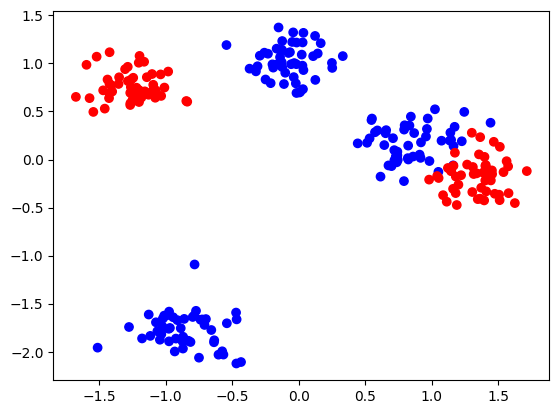

In [184]:
from sklearn.datasets import make_blobs
torch.manual_seed(1)
np.random.seed(42)
X, y = make_blobs([50, 50, 50, 50, 50])
# X, y = make_blobs([20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])
X = (X - X.mean(0)) / X.std(0)
y %= 2

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
train_ds = TensorDataset(X, y)


colors = np.array(['blue', 'red'])
plt.scatter(X[:, 0], X[:, 1], c=colors[y])
plt.show()

In [185]:
from lightning import Trainer
from dal_toolbox.models.laplace import LaplaceLayer, LaplaceModel

class Net(torch.nn.Module):
    def __init__(self, mean_field_factor, cov_likelihood):
        super().__init__()
        self.layer1 = nn.Linear(2, 100)
        self.layer2 = LaplaceLayer(in_features=100, out_features=2, mean_field_factor=mean_field_factor, cov_likelihood=cov_likelihood)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x, return_features=return_features)
        return x
    
    def forward_mean_field(self, x):
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2.forward_mean_field(x)
        return x

    @torch.no_grad()
    def get_logits(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for batch in dataloader:
            inputs = batch[0]
            logits = self.forward_mean_field(inputs.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

    # fisher embedding for bait (assumes cross-entropy loss)
    @torch.no_grad()
    def get_exp_grad_representation(self, dataloader):
        self.eval()
        feature_dim = 2
        num_classes = 2

        embedding = []
        for batch in dataloader:
            inputs = batch[0]

            logits = self(inputs)

            logits = logits.cpu()
            probas = logits.softmax(-1)
            features = inputs.cpu()

            embedding_batch = torch.zeros([len(inputs), num_classes, feature_dim * num_classes])
            for ind in range(num_classes):
                factor = torch.nn.functional.one_hot(torch.tensor(ind), num_classes=num_classes) - probas
                embedding_batch[:, ind] = (factor[:, :, None] * features[:, None, :]).flatten(-2)
                embedding_batch[:, ind] =  embedding_batch[:, ind] * torch.sqrt(probas[:, ind].view(-1, 1))
            embedding.append(embedding_batch)
        return torch.cat(embedding)


In [188]:
torch.manual_seed(42)
model = Net(10, cov_likelihood='gaussian')
loader = DataLoader(TensorDataset(X, y, torch.arange(len(X))), shuffle=False, batch_size=100)

In [187]:
repr_all = model.get_exp_grad_representation(dataloader=loader)
fisher = torch.matmul(repr_all.transpose(1, 2), repr_all) / len(repr_all)
fisher = torch.sum(fisher, dim=0)

idxs_lb = [1, 2, 3]
repr_labeled = repr_all[idxs_lb]
init = torch.matmul(repr_labeled.transpose(1, 2), repr_labeled) / len(repr_labeled)
init = torch.sum(init, dim=0)
fisher, init

(tensor([[ 0.2484,  0.0197, -0.2484, -0.0197],
         [ 0.0197,  0.2474, -0.0197, -0.2474],
         [-0.2484, -0.0197,  0.2484,  0.0197],
         [-0.0197, -0.2474,  0.0197,  0.2474]]),
 tensor([[ 0.3250,  0.0111, -0.3250, -0.0111],
         [ 0.0111,  0.4266, -0.0111, -0.4266],
         [-0.3250, -0.0111,  0.3250,  0.0111],
         [-0.0111, -0.4266,  0.0111,  0.4266]]))

In [182]:
def select(X, K, fisher, iterates, lamb=1, nLabeled=0):

    numEmbs = len(X)
    indsAll = []
    dim = X.shape[-1]
    rank = X.shape[-2]

    currentInv = torch.inverse(lamb * torch.eye(dim).cuda() + iterates.cuda() * nLabeled / (nLabeled + K))
    X = X * np.sqrt(K / (nLabeled + K))
    fisher = fisher.cuda()

    # forward selection, over-sample by 2x
    # print('forward selection...', flush=True)
    over_sample = 2
    for i in range(int(over_sample * K)):

        # check trace with low-rank updates (woodbury identity)
        xt_ = X.cuda()
        innerInv = torch.inverse(torch.eye(rank).cuda() + xt_ @ currentInv @ xt_.transpose(1, 2)).detach()
        innerInv[torch.where(torch.isinf(innerInv))] = torch.sign(
            innerInv[torch.where(torch.isinf(innerInv))]) * np.finfo('float32').max
        traceEst = torch.diagonal(xt_ @ currentInv @ fisher @ currentInv @
                                  xt_.transpose(1, 2) @ innerInv, dim1=-2, dim2=-1).sum(-1)


        # get the smallest unselected item
        traceEst = traceEst.detach().cpu().numpy()
        for j in np.argsort(traceEst)[::-1]:
            if j not in indsAll:
                ind = j
                break

        indsAll.append(ind)
        print(i, ind, traceEst[ind], flush=True)

        # commit to a low-rank update
        xt_ = X[ind].unsqueeze(0).cuda()
        innerInv = torch.inverse(torch.eye(rank).cuda() + xt_ @ currentInv @ xt_.transpose(1, 2)).detach()
        currentInv = (currentInv - currentInv @ xt_.transpose(1, 2) @ innerInv @ xt_ @ currentInv).detach()[0]

    # backward pruning
    # print('backward pruning...', flush=True)
    for i in range(len(indsAll) - K):

        # select index for removal
        xt_ = X[indsAll].cuda()
        innerInv = torch.inverse(-1 * torch.eye(rank).cuda() + xt_ @
                                 currentInv @ xt_.transpose(1, 2)).detach()
        traceEst = torch.diagonal(xt_ @ currentInv @ fisher @ currentInv @
                                  xt_.transpose(1, 2) @ innerInv, dim1=-2, dim2=-1).sum(-1)
        delInd = torch.argmin(-1 * traceEst).item()
        print(len(indsAll) - i, indsAll[delInd], -1 * traceEst[delInd].item(), flush=True)

        # low-rank update (woodbury identity)
        xt_ = X[indsAll[delInd]].unsqueeze(0).cuda()
        innerInv = torch.inverse(-1 * torch.eye(rank).cuda() + xt_ @
                                 currentInv @ xt_.transpose(1, 2)).detach()
        currentInv = (currentInv - currentInv @ xt_.transpose(1, 2) @ innerInv @ xt_ @ currentInv).detach()[0]

        del indsAll[delInd]

    return indsAll
select(repr_all, 10, fisher, init, lamb=1, nLabeled=3)

forward selection...
0 12 0.2967714
1 146 0.21011451
2 123 0.063748166
3 56 0.053702854
4 100 0.028956102
5 22 0.025757667
6 154 0.017434912
7 9 0.015674874
8 233 0.011084672
9 198 0.009867018
10 37 0.008203797
11 112 0.006947199
12 39 0.006216768
13 3 0.0054471446
14 88 0.004679352
15 120 0.004120648
16 122 0.00375218
17 30 0.0032777684
18 142 0.0031120493
19 52 0.0026878542
backward pruning...
20 52 0.0026878532953560352
18 142 0.0031120451167225838
16 30 0.0032777634914964437
14 122 0.0037521799094974995
12 120 0.004120643250644207
10 88 0.004679346457123756
8 3 0.005447142757475376
6 233 0.006054596044123173
4 112 0.007328263018280268
2 39 0.008081583306193352


[12, 146, 123, 56, 100, 22, 154, 9, 198, 37]

In [ ]:
select(repr_all)

In [18]:
import torch
import torch.nn.functional as F


num_samples, num_dims, num_classes = 1, 10, 5  # Example dimensions

X = torch.randn(num_samples, num_dims, requires_grad=True)
y = torch.randint(0, num_classes, (num_samples,))
theta = torch.randn(num_dims, num_classes, requires_grad=True)


logits = X @ theta  # Matrix multiplication

loss = F.cross_entropy(logits, y)
loss.backward()

# compute
probas = F.softmax(logits, dim=1).detach()
fisher = torch.zeros(num_dims, num_dims)
for cl in range(num_classes):
    fisher += (probas[:, cl] * torch.outer(theta.grad[:, cl], theta.grad[:, cl]))

In [36]:
import torch
import torch.nn.functional as F

torch.manual_seed(42)
num_samples, num_dims, num_classes = 100, 10, 5

X = torch.randn(num_samples, num_dims)
y = torch.randint(0, num_classes, (num_samples,))
theta = torch.randn(num_dims, num_classes, requires_grad=True)

logits = X @ theta  # Matrix multiplication
loss = F.cross_entropy(logits, y)

loss.backward()

probas = F.softmax(logits, dim=1).detach()

fisher = torch.zeros(num_dims, num_dims)
for i in range(num_samples):
    for cl in range(num_classes):
        # Select the gradient for the current class 'cl'
        grad_log_likelihood = -theta.grad[:, cl]
        # Compute the outer product of the gradient with itself
        outer_product = torch.outer(grad_log_likelihood, grad_log_likelihood)
        # Weight by the probability of the class for the current sample
        fisher += probas[i, cl] * outer_product
    break
fisher /= num_samples

print(fisher)


tensor([[ 1.1647e-04,  4.7834e-05, -1.5178e-05, -1.3316e-05,  4.3267e-05,
          1.7672e-05,  1.9929e-05,  6.1598e-05, -4.0735e-06,  3.2648e-05],
        [ 4.7834e-05,  9.8525e-05, -4.1623e-05, -1.0837e-05,  4.9039e-05,
          2.7706e-05,  2.2825e-05,  9.4599e-05, -9.8785e-07,  8.7899e-05],
        [-1.5178e-05, -4.1623e-05,  2.0633e-05, -1.9902e-06, -1.8853e-05,
         -8.5995e-06, -2.9543e-06, -3.5528e-05, -9.5062e-06, -3.3952e-05],
        [-1.3316e-05, -1.0837e-05, -1.9902e-06,  2.3375e-05, -1.0467e-06,
         -1.9676e-05, -2.4025e-05, -1.1064e-05,  4.5958e-05, -2.8415e-05],
        [ 4.3267e-05,  4.9039e-05, -1.8853e-05, -1.0467e-06,  3.6423e-05,
          5.7488e-06,  8.0973e-06,  5.9910e-05,  1.9611e-05,  3.1521e-05],
        [ 1.7672e-05,  2.7706e-05, -8.5995e-06, -1.9676e-05,  5.7488e-06,
          2.3327e-05,  2.2029e-05,  2.0270e-05, -4.0531e-05,  4.2336e-05],
        [ 1.9929e-05,  2.2825e-05, -2.9543e-06, -2.4025e-05,  8.0973e-06,
          2.2029e-05,  2.6246e-0